<a href="https://colab.research.google.com/github/tsutsumi-ozro/NLP-100knocks/blob/main/ch08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 第8章: ニューラルネット
第6章で取り組んだニュース記事のカテゴリ分類を題材として，ニューラルネットワークでカテゴリ分類モデルを実装する．なお，この章ではPyTorch, TensorFlow, Chainerなどの機械学習プラットフォームを活用せよ．

### 70. 単語ベクトルの和による特徴量
※問題文に数式が多く含まれているため、記述しない。<br>
[問題文](https://nlp100.github.io/ja/ch08.html)

問題50と同じことをする(閲覧している解答が変わっているため若干コードにも変化はあるが、やっていることはほとんど同じ)

In [1]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip /content/NewsAggregatorDataset.zip

--2023-01-05 09:34:03--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas 100%[===================>]  27.87M  47.1MB/s    in 0.6s    

2023-01-05 09:34:04 (47.1 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203/29224203]

Archive:  /content/NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
columns = ['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP']
df = pd.read_csv('/content/newsCorpora.csv', header=None, sep='\t', names=columns)

df = df.loc[df['PUBLISHER'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']), ['TITLE', 'CATEGORY']]

train, valid_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=123, stratify=df['CATEGORY'])
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=123, stratify=valid_test['CATEGORY'])

問題60で使用した学習済み単語ベクトルをダウンロード

In [3]:
FILE_ID = "0B7XkCwpI5KDYNlNUTTlSS21pQmM"
FILE_NAME = "GoogleNews-vectors-negative300.bin.gz"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=$FILE_ID' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=$FILE_ID" -O $FILE_NAME && rm -rf /tmp/cookies.txt

--2023-01-05 09:34:21--  https://docs.google.com/uc?export=download&confirm=&id=0B7XkCwpI5KDYNlNUTTlSS21pQmM
Resolving docs.google.com (docs.google.com)... 172.253.117.139, 172.253.117.100, 172.253.117.102, ...
Connecting to docs.google.com (docs.google.com)|172.253.117.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-8s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/vopg7b3h1un25794id3lghsmb3v55uie/1672911225000/06848720943842814915/*/0B7XkCwpI5KDYNlNUTTlSS21pQmM?e=download&uuid=6c5a0e44-a25c-429b-ae5c-9070855a80ac [following]
--2023-01-05 09:34:21--  https://doc-0g-8s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/vopg7b3h1un25794id3lghsmb3v55uie/1672911225000/06848720943842814915/*/0B7XkCwpI5KDYNlNUTTlSS21pQmM?e=download&uuid=6c5a0e44-a25c-429b-ae5c-9070855a80ac
Resolving doc-0g-8s-docs.googleusercontent.com (doc-0g-8s-docs.googleusercontent.com)... 74.125.142.132, 2607:f8b0:40

In [4]:
from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format('/content/GoogleNews-vectors-negative300.bin.gz', binary=True)

maketransはマッピングするのか<br>
https://www.w3big.com/ja/python/att-string-maketrans.html<br>
こちらstring<br>
https://docs.python.org/ja/3/library/string.html<br>
返り値はこれをしてる<br>

$\boldsymbol{x}_i = \frac{1}{T_i} \sum_{t=1}^{T_i} \mathrm{emb}(w_{i,t})$


In [5]:
import string
import torch

def transform_w2v(text):
    #!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~を空白に置換しようとしてるわけ
    table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    words = text.translate(table).split()
    #ここでベクトル変換してる
    vec = [model[word] for word in words if word in model]

    return torch.tensor(sum(vec)/len(vec))

In [9]:
X_train = torch.stack([transform_w2v(text) for text in train['TITLE']])
X_valid = torch.stack([transform_w2v(text) for text in valid['TITLE']])
X_test = torch.stack([transform_w2v(text) for text in test['TITLE']])

In [7]:
category_dict = {'b':0, 't':1, 'e':2, 'm':3}
y_train = torch.tensor(train['CATEGORY'].map(lambda x: category_dict[x]).values)
y_valid = torch.tensor(valid['CATEGORY'].map(lambda x: category_dict[x]).values)
y_test = torch.tensor(test['CATEGORY'].map(lambda x: category_dict[x]).values)

In [10]:
torch.save(X_train, 'X_train.pt')
torch.save(X_valid, 'X_valid.pt')
torch.save(X_test, 'X_test.pt')
torch.save(y_train, 'y_train.pt')
torch.save(y_valid, 'y_valid.pt')
torch.save(y_test, 'y_test.pt')

### 71. 単層ニューラルネットワークによる予測
※問題文に数式が含まれているため、記述しない。<br>
[問題文](https://nlp100.github.io/ja/ch08.html)

https://pytorch.org/docs/stable/generated/torch.nn.Linear.html?highlight=torch+nn+linear#torch.nn.Linear<br>
https://pytorch.org/docs/stable/nn.init.html?highlight=nn+init+normal_#torch.nn.init.normal_<br>


In [11]:
from torch import nn

class SLPNet(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.fc = nn.Linear(input_size, output_size, bias=False)
        nn.init.normal_(self.fc.weight, 0.0, 1.0)
    
    def forward(self, x):
        x = self.fc(x)
        return x

model = SLPNet(300, 4)
y_hat_1 = torch.softmax(model(X_train[:1]), dim=-1)
print(y_hat_1)

tensor([[0.0250, 0.0098, 0.7128, 0.2524]], grad_fn=<SoftmaxBackward0>)


In [13]:
y_hat = torch.softmax(model(X_train[:4]), dim=-1)
print(y_hat)

tensor([[0.0250, 0.0098, 0.7128, 0.2524],
        [0.5622, 0.2795, 0.1034, 0.0548],
        [0.3535, 0.0579, 0.3531, 0.2355],
        [0.1658, 0.0952, 0.3122, 0.4268]], grad_fn=<SoftmaxBackward0>)


### 72. 損失と勾配の計算
※問題文に数式が含まれているため、記述しない。<br>
[問題文](https://nlp100.github.io/ja/ch08.html)

In [15]:
loss_fn = nn.CrossEntropyLoss()
loss_x1 = loss_fn(model(X_train[:1]), y_train[:1])
model.zero_grad()
loss_x1.backward()
print(f'損失: {loss_x1:.4f}')
print(f'勾配: \n{model.fc.weight.grad}')

損失: 3.6879
勾配: 
tensor([[ 0.0165, -0.1285,  0.0709,  ..., -0.0385, -0.0217, -0.0179],
        [-0.0002,  0.0013, -0.0007,  ...,  0.0004,  0.0002,  0.0002],
        [-0.0121,  0.0939, -0.0519,  ...,  0.0281,  0.0159,  0.0131],
        [-0.0043,  0.0333, -0.0184,  ...,  0.0100,  0.0056,  0.0046]])


In [16]:
loss_x1_to_x4 = loss_fn(model(X_train[:4]), y_train[:4])
model.zero_grad()
loss_x1_to_x4.backward()
print(f'損失: {loss_x1_to_x4:.4f}')
print(f'勾配: \n{model.fc.weight.grad}')

損失: 1.7752
勾配: 
tensor([[ 0.0324, -0.0537,  0.0301,  ..., -0.0091, -0.0178, -0.0071],
        [-0.0094, -0.0001, -0.0073,  ...,  0.0020, -0.0003, -0.0022],
        [-0.0137,  0.0317, -0.0161,  ...,  0.0056,  0.0119,  0.0060],
        [-0.0093,  0.0221, -0.0066,  ...,  0.0016,  0.0062,  0.0034]])


### 73.  確率的勾配降下法による学習
確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，行列Wを学習せよ．なお，学習は適当な基準で終了させればよい（例えば「100エポックで終了」など）．



In [34]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class NewsDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        return [self.X[index], self.y[index]]

dataset_train = NewsDataset(X_train, y_train)
dataset_valid = NewsDataset(X_valid, y_valid)
dataset_test = NewsDataset(X_test, y_test)

dataloader_train = DataLoader(dataset_train, batch_size=64, shuffle=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=32, shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)

In [36]:
from torch.nn.modules.loss import CrossEntropyLoss

model = SLPNet(300, 4)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    loss_train = 0.0
    for i, (inputs, labels) in enumerate(dataloader_train):
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        loss_train += loss.item()
    
    loss_train = loss_train / i

    model.eval()
    with torch.no_grad():
        inputs, labels = next(iter(dataloader_valid))
        outputs = model(inputs)
        loss_valid = loss_fn(outputs, labels)
    if (epoch+1)%10==0:
        print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, loss_valid: {loss_valid:.4f}')  

epoch: 10, loss_train: 0.5595, loss_valid: 0.6710
epoch: 20, loss_train: 0.4455, loss_valid: 0.5331
epoch: 30, loss_train: 0.3959, loss_valid: 0.4725
epoch: 40, loss_train: 0.3676, loss_valid: 0.4423
epoch: 50, loss_train: 0.3487, loss_valid: 0.4230
epoch: 60, loss_train: 0.3350, loss_valid: 0.4104
epoch: 70, loss_train: 0.3239, loss_valid: 0.4011
epoch: 80, loss_train: 0.3157, loss_valid: 0.3948
epoch: 90, loss_train: 0.3084, loss_valid: 0.3895
epoch: 100, loss_train: 0.3022, loss_valid: 0.3852


### 74. 正解率の計測
問題73で求めた行列を用いて学習データおよび評価データの事例を分類したとき，その正解率をそれぞれ求めよ．

In [37]:
def calculate_accuracy(model, loader):
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            pred = torch.argmax(outputs, dim=-1)
            total += len(inputs)
            #sum? 0 or 1の出力だと思ってたけども.
            # argmaxのdocumentを読んで理解
            # https://pytorch.org/docs/stable/generated/torch.argmax.html?highlight=torch+argmax#torch.argmax
            correct += (pred==labels).sum().item()
    return correct / total

acc_train = calculate_accuracy(model, dataloader_train)
acc_test = calculate_accuracy(model, dataloader_test)
print(f'train accuracy score: {acc_train:.3f}')
print(f'test accuracy score：{acc_test:.3f}')

train accuracy score: 0.896
test accuracy score：0.891


### 75. 損失と正解率のプロット
問題73のコードを改変し，各エポックのパラメータ更新が完了するたびに，訓練データでの損失，正解率，検証データでの損失，正解率をグラフにプロットし，学習の進捗状況を確認できるようにせよ．

In [38]:
def calculate_loss_and_accuracy(model, loss_fn, loader):
    model.eval()
    loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            loss += loss_fn(outputs, labels)
            pred = torch.argmax(outputs, dim=-1)
            total += len(inputs)
            correct += (pred==labels).sum().item()
    return loss/len(loader), correct/total

In [40]:
model = SLPNet(300, 4)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

num_epochs = 100
log_train = []
log_valid = []

for epoch in range(num_epochs):
    model.train()
    for inputs, labels in dataloader_train:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
    
    loss_train, acc_train = calculate_loss_and_accuracy(model, loss_fn, dataloader_train)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, loss_fn, dataloader_valid)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    if (epoch+1)%10==0:
        print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}')

epoch: 10, loss_train: 0.5657, accuracy_train: 0.7938, loss_valid: 0.5734, accuracy_valid: 0.7901
epoch: 20, loss_train: 0.4451, accuracy_train: 0.8385, loss_valid: 0.4610, accuracy_valid: 0.8276
epoch: 30, loss_train: 0.3936, accuracy_train: 0.8611, loss_valid: 0.4138, accuracy_valid: 0.8508
epoch: 40, loss_train: 0.3647, accuracy_train: 0.8717, loss_valid: 0.3875, accuracy_valid: 0.8591
epoch: 50, loss_train: 0.3457, accuracy_train: 0.8786, loss_valid: 0.3698, accuracy_valid: 0.8628
epoch: 60, loss_train: 0.3317, accuracy_train: 0.8834, loss_valid: 0.3573, accuracy_valid: 0.8636
epoch: 70, loss_train: 0.3217, accuracy_train: 0.8874, loss_valid: 0.3478, accuracy_valid: 0.8688
epoch: 80, loss_train: 0.3134, accuracy_train: 0.8920, loss_valid: 0.3400, accuracy_valid: 0.8718
epoch: 90, loss_train: 0.3063, accuracy_train: 0.8956, loss_valid: 0.3335, accuracy_valid: 0.8748
epoch: 100, loss_train: 0.3003, accuracy_train: 0.8980, loss_valid: 0.3281, accuracy_valid: 0.8786


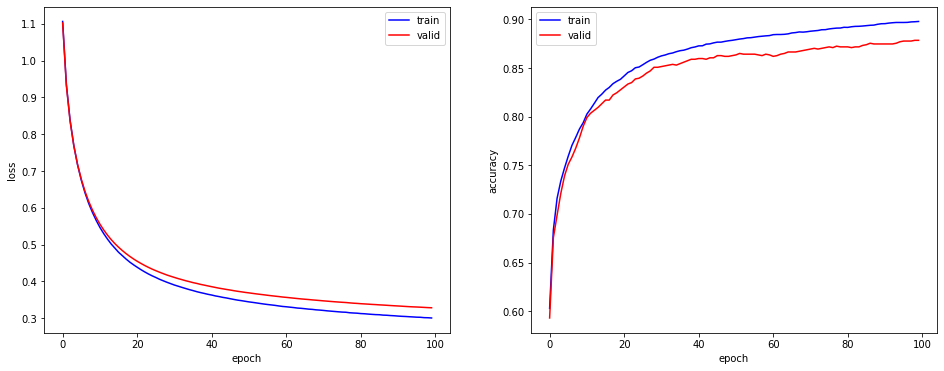

In [41]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].plot(np.array(log_train).T[0], label='train', color='blue')
ax[0].plot(np.array(log_valid).T[0], label='valid', color='red')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()

ax[1].plot(np.array(log_train).T[1], label='train', color='blue')
ax[1].plot(np.array(log_valid).T[1], label='valid', color='red')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()

plt.show()

### 76. チェックポイント
問題75のコードを改変し，各エポックのパラメータ更新が完了するたびに，チェックポイント（学習途中のパラメータ（重み行列など）の値や最適化アルゴリズムの内部状態）をファイルに書き出せ．

### 77. ミニバッチ化
問題76のコードを改変し，B事例ごとに損失・勾配を計算し，行列Wの値を更新せよ（ミニバッチ化）．Bの値を1,2,4,8,…と変化させながら，1エポックの学習に要する時間を比較せよ．

### 78. GPU上での学習
問題77のコードを改変し，GPU上で学習を実行せよ．

### 79. 多層ニューラルネットワーク
問題78のコードを改変し，バイアス項の導入や多層化など，ニューラルネットワークの形状を変更しながら，高性能なカテゴリ分類器を構築せよ．